# PROYECCIONES INDEC 2025- para el amba

### Descripcion de las predicciones

In [2]:
## Imports

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



from utils import read_table_into_dataframe
from utils import create_table_pdf
from utils import  dataframe_to_latex
from utils import dataframe_to_image

In [3]:
### CONNECT TO POSTGRES DATABASE
## AMBA

import psycopg2

# Establish connection parameters
dbname = 'AMBA'
user = 'postgres'
password = 'Ferm1987'
host = 'localhost'  # By default, localhost
port = '5432'  # By default, 5432

# Connect to the PostgreSQL database
try:
    conn = psycopg2.connect(
        dbname=dbname,
        user=user,
        password=password,
        host=host,
        port=port
    )

    # Create a cursor object
    cursor = conn.cursor()

    # Execute a query
    cursor.execute("SELECT version();")
    db_version = cursor.fetchone()
    print("Connected to:", db_version)

    # Commit the transaction
    conn.commit()

except psycopg2.Error as e:
    print("Error connecting to PostgreSQL:", e)

finally:
    # Close the cursor and connection
    if 'cursor' in locals() and cursor is not None:
        cursor.close()
    # if 'conn' in locals() and conn is not None:
    #     conn.close()


Connected to: ('PostgreSQL 16.1, compiled by Visual C++ build 1937, 64-bit',)


In [5]:
# Read vCensosAmba
df = read_table_into_dataframe('public.proyecciones')
df=df.sort_values(by=['Departamento', 'ano'])
if df is not None:
    print(df)
dataframe_to_latex(df.head(10), 'proyecciones2025.tex')

    # Example usage:
# # Assuming 'df' is your DataFrame
# dataframe_to_image(df.head(), 'output', 'svg')  # Save as SVG image
# dataframe_to_image(df.head(), 'output', 'jpeg') # Save as JPEG image



      id CodigoDpto   ano     Departamento  Poblacion  Varones  Mujeres
0      1       6028  2010  Almirante Brown     557025   273352   283673
24    25       6028  2011  Almirante Brown     561349   275570   285779
48    49       6028  2012  Almirante Brown     565509   277794   287715
72    73       6028  2013  Almirante Brown     569911   279980   289931
96    97       6028  2014  Almirante Brown     574263   282143   292120
..   ...        ...   ...              ...        ...      ...      ...
335  336       6861  2023    Vicente López     266538   125851   140687
357  358       6861  2024    Vicente López     493467   244564   248903
359  360       6861  2024    Vicente López     266203   125780   140423
381  382       6861  2025    Vicente López     500615   248235   252380
383  384       6861  2025    Vicente López     265885   125719   140166

[384 rows x 7 columns]


In [ ]:
df.describe()
df.shape
df.columns
df.dtypes
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            384 non-null    int64 
 1   CodigoDpto    384 non-null    object
 2   ano           384 non-null    int64 
 3   Departamento  384 non-null    object
 4   Poblacion     384 non-null    int64 
 5   Varones       384 non-null    int64 
 6   Mujeres       384 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 21.1+ KB


id              0
CodigoDpto      0
ano             0
Departamento    0
Poblacion       0
Varones         0
Mujeres         0
dtype: int64

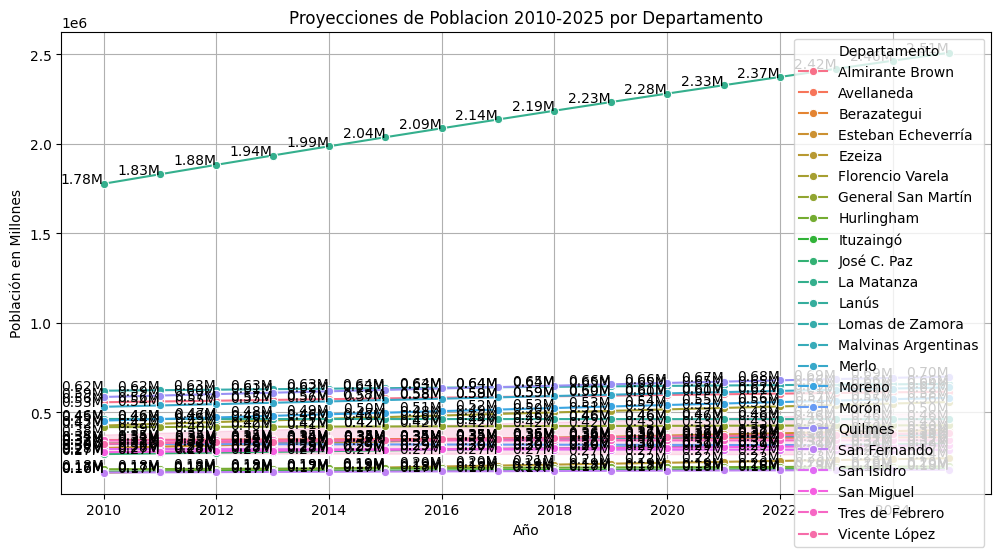

In [7]:

    # Create the line plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x='ano', y='Poblacion', hue='Departamento', marker='o')

    # Add values for each data point in millions
    for _, row in df.iterrows():
        plt.text(row['ano'], row['Poblacion'], f"{row['Poblacion'] / 1e6:.2f}M", ha='right')

    # Add labels to the axes and show the plot
    plt.xlabel('Año' )
    plt.ylabel('Población en Millones')
    plt.title('Proyecciones de Poblacion 2010-2025 por Departamento')
    plt.grid(True)
    plt.show()




In [12]:
# Classify the departments based on population thresholds for the year 2010
population_bins = [-np.inf, 300000, 700000, np.inf]
population_labels = ['Below 300k', '300k-700k', 'Above 700k']

df['Population_Category'] = pd.cut(df[df['ano'] == 2010]['Poblacion'],
                                   bins=population_bins,
                                   labels=population_labels)

# Extract department categories
dept_categories = df.groupby('Departamento')['Population_Category'].last().to_dict()
print(dept_categories)

{'Almirante Brown': '300k-700k', 'Avellaneda': '300k-700k', 'Berazategui': '300k-700k', 'Esteban Echeverría': '300k-700k', 'Ezeiza': 'Below 300k', 'Florencio Varela': '300k-700k', 'General San Martín': '300k-700k', 'Hurlingham': 'Below 300k', 'Ituzaingó': 'Below 300k', 'José C. Paz': 'Below 300k', 'La Matanza': 'Above 700k', 'Lanús': '300k-700k', 'Lomas de Zamora': '300k-700k', 'Malvinas Argentinas': '300k-700k', 'Merlo': '300k-700k', 'Moreno': '300k-700k', 'Morón': '300k-700k', 'Quilmes': '300k-700k', 'San Fernando': 'Below 300k', 'San Isidro': 'Below 300k', 'San Miguel': 'Below 300k', 'Tres de Febrero': '300k-700k', 'Vicente López': 'Below 300k'}


In [16]:
# Initialize dictionaries to store department names for each category
dept_names_below_300k = []
dept_names_300k_to_700k = []
dept_names_above_700k = []

# Iterate over dept_categories to collect department names in each category
for dept, category in dept_categories.items():
    if category == 'Below 300k':
        dept_names_below_300k.append(dept)
    elif category == '300k-700k':
        dept_names_300k_to_700k.append(dept)
    elif category == 'Above 700k':
        dept_names_above_700k.append(dept)

# Print department names in each category
print("Departments with population Below 300k:")
print(dept_names_below_300k)

print("\nDepartments with population Between 300k and 700k:")
print(dept_names_300k_to_700k)

print("\nDepartments with population Above 700k:")
print(dept_names_above_700k)


Departments with population Below 300k:
['Ezeiza', 'Hurlingham', 'Ituzaingó', 'José C. Paz', 'San Fernando', 'San Isidro', 'San Miguel', 'Vicente López']

Departments with population Between 300k and 700k:
['Almirante Brown', 'Avellaneda', 'Berazategui', 'Esteban Echeverría', 'Florencio Varela', 'General San Martín', 'Lanús', 'Lomas de Zamora', 'Malvinas Argentinas', 'Merlo', 'Moreno', 'Morón', 'Quilmes', 'Tres de Febrero']

Departments with population Above 700k:
['La Matanza']


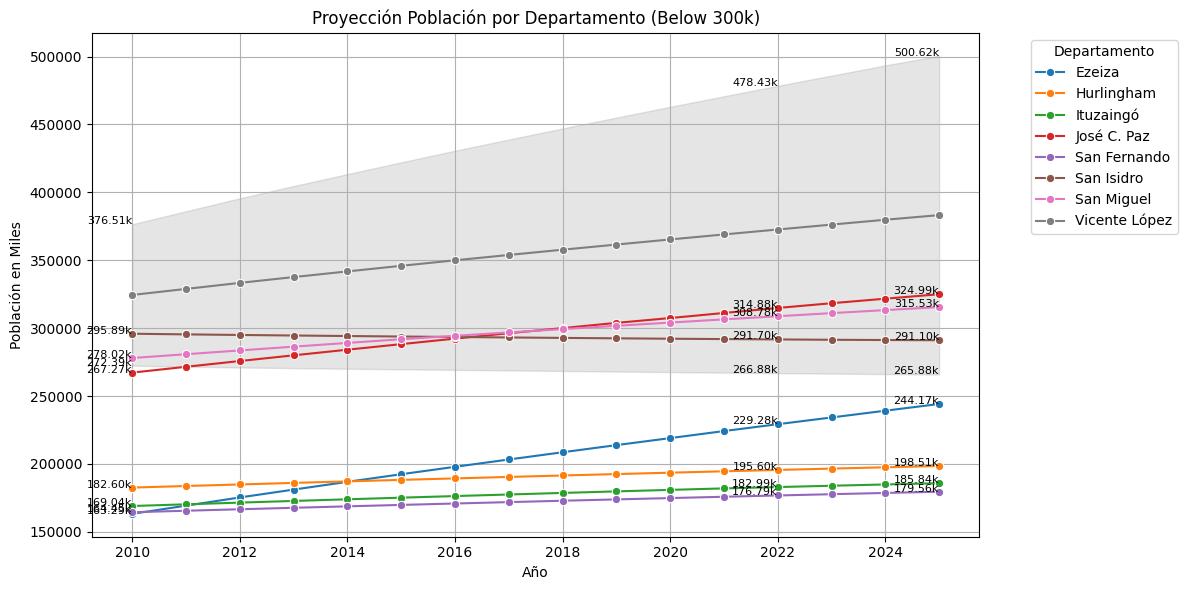

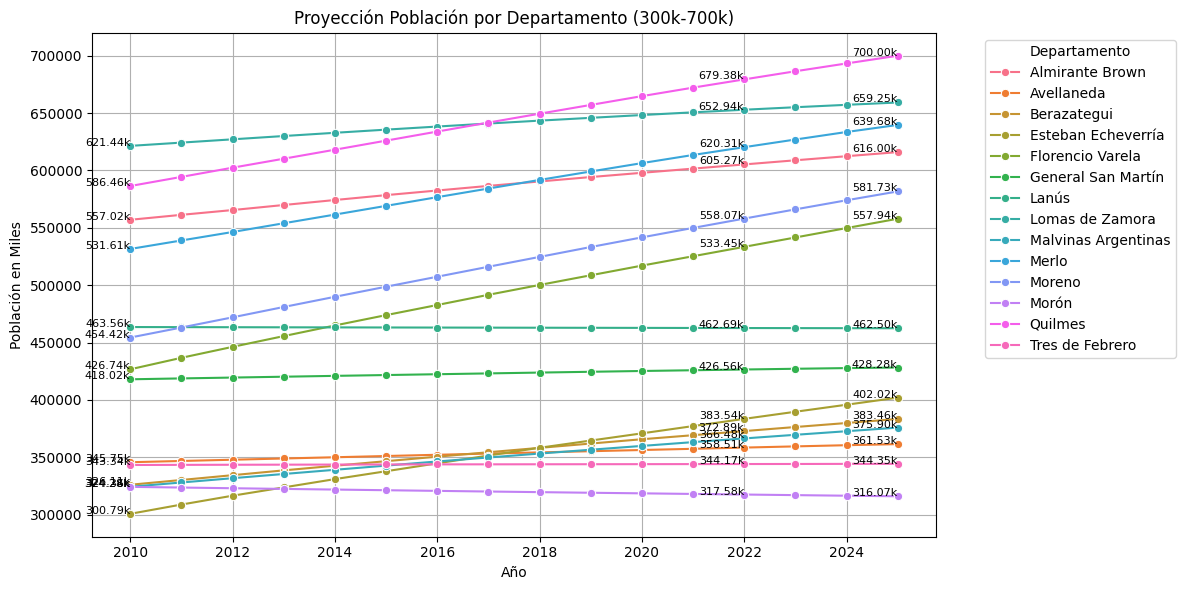

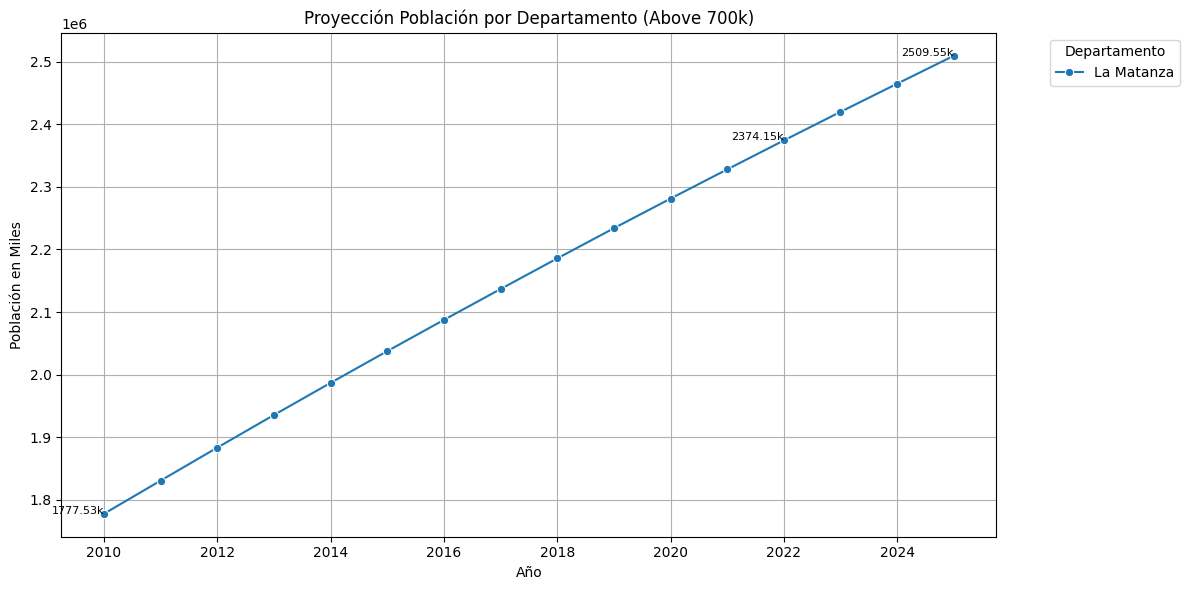

In [27]:
# Function to create line plot for a specific category
def create_line_plot(df_category, category_name):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_category, x='ano', y='Poblacion', hue='Departamento', marker='o')
    
    # Add data labels for specific years
    for year in [2010, 2022, 2025]:
        data_point = df_category[df_category['ano'] == year]
        for _, row in data_point.iterrows():
            plt.text(row['ano'], row['Poblacion'], f"{row['Poblacion'] / 1e3:.2f}k", ha='right', fontsize=8)
    
    plt.xlabel('Año')
    plt.ylabel('Población en Miles')
    plt.title(f'Proyección Población por Departamento ({category_name})')
    plt.legend(title='Departamento', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Filter the original DataFrame based on department names for each population category
df_below_300k = df[df['Departamento'].isin(dept_names_below_300k)]
df_300k_to_700k = df[df['Departamento'].isin(dept_names_300k_to_700k)]
df_above_700k = df[df['Departamento'].isin(dept_names_above_700k)]





# Filter the DataFrame for each population category and create line plots
create_line_plot(df_below_300k, 'Below 300k')
create_line_plot(df_300k_to_700k, '300k-700k')
create_line_plot(df_above_700k, 'Above 700k')

